In [ ]:
# Exporting the notebook. It may take several seconds....

[NbConvertApp] Converting notebook test_demo.ipynb to script
[NbConvertApp] Writing 26059 bytes to test_demo.py


xgboost==1.2.1
pandas==0.25.3
scipy==1.5.3
matplotlib==3.0.2
numpy==1.19.2
seaborn==0.9.0
scikit_learn==0.23.2


INFO: Successfully output requirements


In [466]:
## $xpr_param_component_name = fetch_data
## $xpr_param_component_type = pipeline_job 
## $xpr_param_global_variables = ["train_data","test_data"]
import numpy as np
import pandas as pd
import os

#from pandas_profiling import ProfileReport

#import sys
#import matplotlib.pyplot as plt
#import seaborn as sns

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)




# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [414]:
# Reading train_data.csv file from local drive and stored inside train_data and index set as 'id'.
train_data = pd.read_csv('train_data.csv', index_col='id')
print("Train data Shape:" ,train_data.shape)

# Reading test_data.csv file from local drive and stored inside test_data and index set as 'id'.
test_data = pd.read_csv('test_data.csv',index_col='id')
print("Test data Shape :" ,test_data.shape)

Train data Shape: (24269, 34)
Test data Shape : (6066, 33)


# Discover and visualize the data to gain insights

In [415]:
## $xpr_param_component_name = explore_data
## $xpr_param_component_type = pipeline_job 
## $xpr_param_global_variables = ["train_data","test_data"]

In [416]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24269 entries, train_0 to train_24268
Data columns (total 34 columns):
county                   24235 non-null object
city                     24269 non-null object
zipcode                  24235 non-null float64
address                  23317 non-null object
state                    24269 non-null object
latitude                 24269 non-null float64
longitude                24269 non-null float64
cemetery_dist_miles      24269 non-null float64
nationalhighway_miles    24269 non-null float64
railline_miles           24269 non-null float64
starbucks_miles          24269 non-null float64
walmart_miles            24269 non-null float64
hospital_miles           24269 non-null float64
physician_dist_miles     24269 non-null float64
dentist_dist_miles       24269 non-null float64
opt_dist_miles           24269 non-null float64
vet_dist_miles           24269 non-null float64
farmers_miles            24269 non-null float64
bed                     

In [417]:
# Function to get a list of the variables that contain missing values and plot by passing the dataframe
import matplotlib.pyplot as plt


def missingValuesInfo(df,plot=False):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(total/len(df)*100, 2)
    temp = pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])
    
    if sum(total) == 0:
        print("No missing values present!")
        return temp.loc[(temp['Total'] > 0)]
    
    if plot:
        f, ax = plt.subplots(figsize=(15, 6))
        plt.xticks(rotation='90')
        sns.barplot(x=temp.index, y=temp['Percent'])
        plt.xlabel('Features', fontsize=15)
        plt.ylabel('Percent of missing values', fontsize=15)
        plt.title('Percent missing data by feature', fontsize=15)
        save_fig("missing_Values_Info")
    return temp.loc[(temp['Total'] > 0)]

Saving figure missing_Values_Info


Total  Percent
property_type   3626    14.94
address          952     3.92
county            34     0.14
zipcode           34     0.14

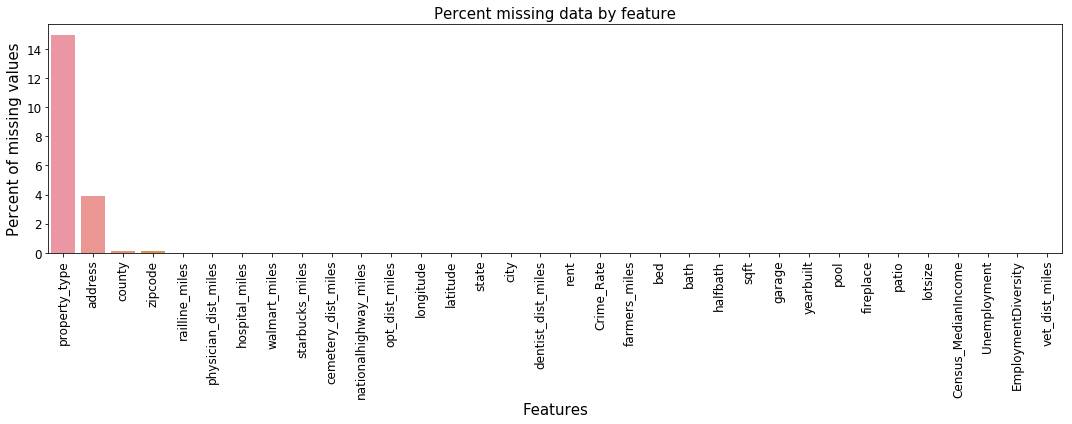

In [418]:
# Check missing values in training and test dataset
#check_missing_values(train_data)
missingValuesInfo(train_data,True)

# Property type has almost 15% of rows with missing values
# Address has almost 4% of rows with missing values
# County and zipcode has less than 0.50% of rows with missing values

# Based on understanding different columns. The missing values possibly happened either due to not recorded or not available.
# county        - Not recorded
# zipcode       - Not recorded
# address       - Not recorded
# property_type - Not recorded

Saving figure missing_Values_Info


Total  Percent
property_type    887    14.62
address          234     3.86
county             4     0.07
zipcode            4     0.07

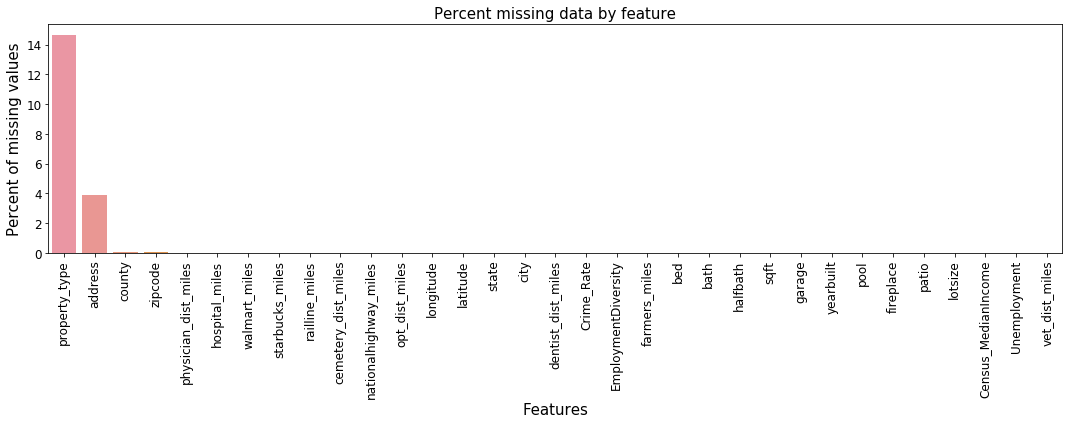

In [419]:
#check_missing_values(test_data)
missingValuesInfo(test_data,True)

In [420]:
train_data.describe()

zipcode      latitude     longitude  cemetery_dist_miles  \
count  24235.000000  24269.000000  24269.000000         24269.000000   
mean   18030.844564     40.080788    -77.241598             1.206987   
std     1477.571555      1.637096      5.817313             0.927508   
min    15001.000000    -12.116930   -149.900278             0.022214   
25%    17111.000000     39.966766    -77.008588             0.818566   
50%    18944.000000     40.130169    -75.475763             1.019586   
75%    19128.000000     40.444389    -75.185042             1.227709   
max    19611.000000     61.218056    -11.706829             9.747778   

       nationalhighway_miles  railline_miles  starbucks_miles  walmart_miles  \
count           24269.000000    24269.000000     24269.000000   24269.000000   
mean                0.290908        1.049048         2.042534       3.528326   
std                 0.364962        1.574878         3.205261       1.794201   
min                 0.000027        0.000248         0.013197       0.118545   
25%                 0.143624        0.465909         0.959076       2.712467   
50%                 0.206222        0.629888         1.348776       3.326397   
75%                 0.281964        0.860038         1.789913       3.870699   
max                 7.920969       28.306430        63.618152      26.409748   

       hospital_miles  physician_dist_miles  dentist_dist_miles  \
count    24269.000000          24269.000000        24269.000000   
mean         2.269302              0.352973            0.712536   
std          2.467797              0.551741            0.993609   
min          0.041096              0.000087            0.000157   
25%          1.160151              0.170974            0.359750   
50%          1.584675              0.229126            0.472933   
75%          2.196950              0.299176            0.611134   
max         32.433629             14.301216           19.823016   

       opt_dist_miles  vet_dist_miles  farmers_miles           bed  \
count    24269.000000    24269.000000   24269.000000  24269.000000   
mean         0.892396       12.419132       1.769471      2.766863   
std          1.092290       17.585042       2.204656      1.446065   
min          0.000157        0.013511       0.012470      1.000000   
25%          0.490856        4.794041       0.740475      2.000000   
50%          0.651244        7.323725       1.094678      3.000000   
75%          0.853274       10.299977       1.703883      3.000000   
max         22.761643      141.184122      35.603985     18.000000   

               bath      halfbath          sqft        garage     yearbuilt  \
count  24269.000000  24269.000000  24269.000000  24269.000000  24269.000000   
mean       1.621122      1.026989   1535.360625      0.291895   1958.995014   
std        0.854438      0.212449    824.447982      0.454644     23.278187   
min        1.000000      1.000000     35.000000      0.000000   1800.000000   
25%        1.000000      1.000000   1000.000000      0.000000   1960.000000   
50%        1.000000      1.000000   1343.000000      0.000000   1960.000000   
75%        2.000000      1.000000   1839.000000      1.000000   1960.000000   
max       12.000000     12.000000   5000.000000      1.000000   2016.000000   

               pool     fireplace         patio       lotsize  \
count  24269.000000  24269.000000  24269.000000  24269.000000   
mean       0.011455      0.206972      0.197948   3669.835108   
std        0.106415      0.405144      0.398461   3185.150540   
min        0.000000      0.000000      0.000000      1.000000   
25%        0.000000      0.000000      0.000000   1712.000000   
50%        0.000000      0.000000      0.000000   2872.730796   
75%        0.000000      0.000000      0.000000   4266.189119   
max        1.000000      1.000000      1.000000  19341.000000   

       Census_MedianIncome  Unemployment  EmploymentDiversity    Crime_Rate  \
count         24269.000000  24

Saving figure Property_type_bar_plots


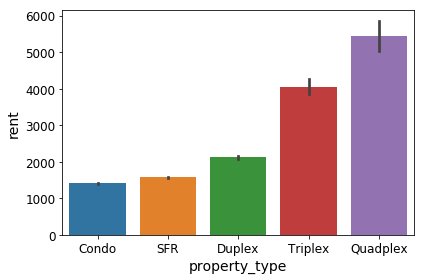

In [421]:
import seaborn as sns
sns.barplot(x=train_data.property_type,y=train_data.rent);
save_fig("Property_type_bar_plots")

Saving figure Property_type_count_plots


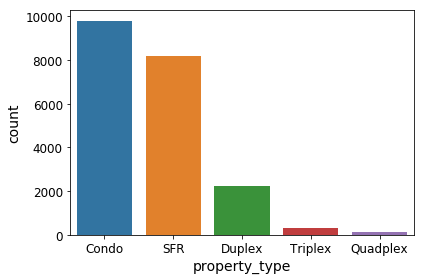

In [422]:
import seaborn as sns
sns.countplot(x=train_data.property_type)
save_fig("Property_type_count_plots")

In [423]:
def correlation1(dataset, threshold):

    d = [] # Create an empty list to store the relations
    
    corr_matrix = dataset.corr() # Get correlation matrix
    
    # Loop through each columns in dataset.
    for i in range(len(corr_matrix.columns)):
        
        # Getting the name of column
        colname = corr_matrix.columns[i]
        
        # Loop through each rows untill range of column
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold: # we are interested in absolute coeff value
                rowname = corr_matrix.index[j]
                d.append([colname,rowname])
                
    return d

Saving figure correlation_matrix_plot


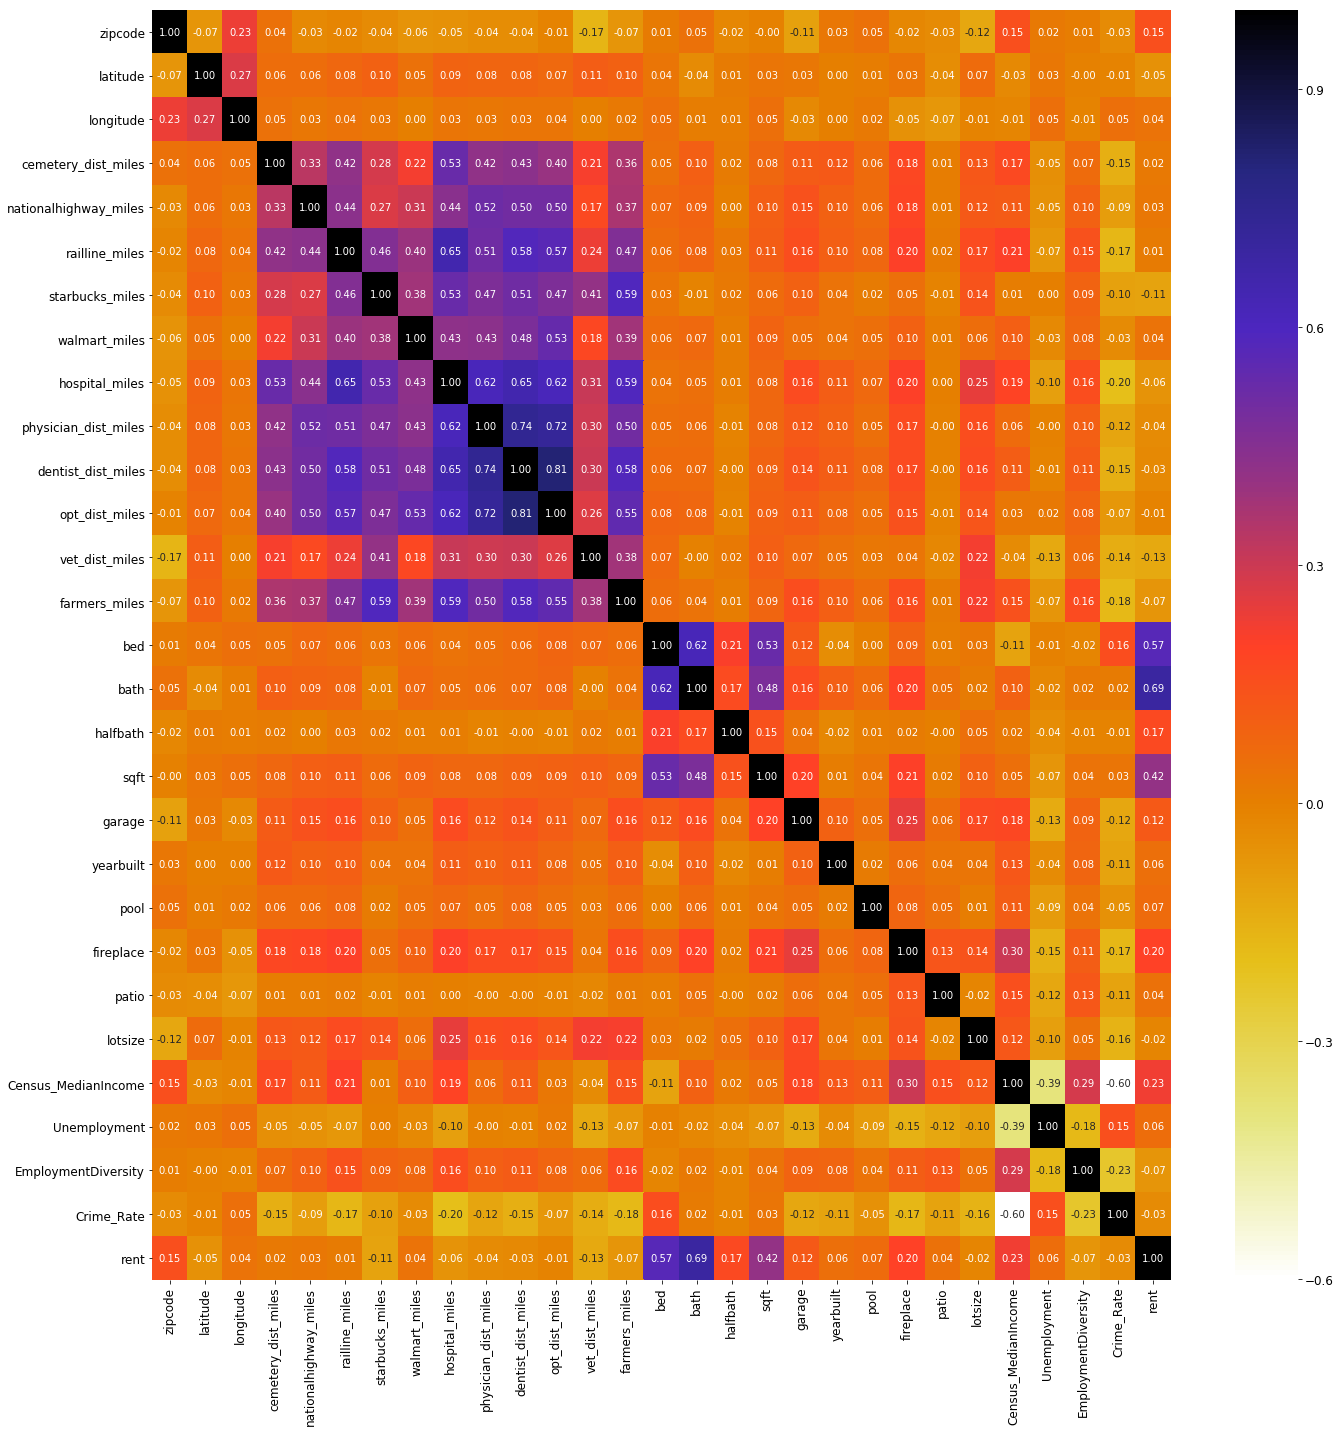

In [424]:
# Calculate correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
corrmat = train_data.corr()

# Plot a heatmap to understand the correlations between different features and also with target variable.
f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corrmat, annot=True,cbar=True, fmt='.2f', cmap=plt.cm.CMRmap_r)
save_fig("correlation_matrix_plot")

Saving figure correlation_top10_plot


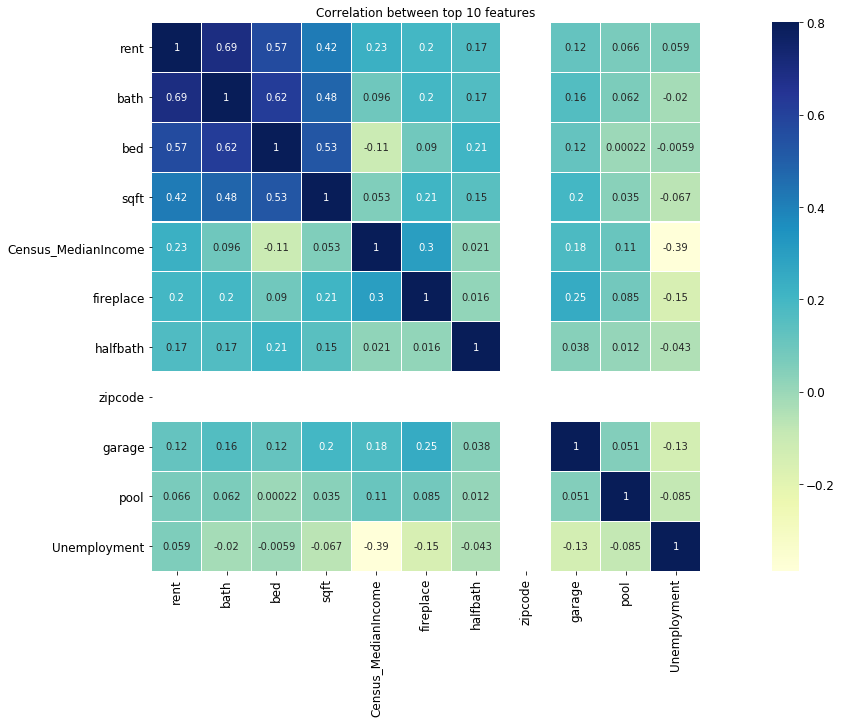

In [425]:
# Plot heatmap of Top 10 correlated features with target variable(rent)
import seaborn as sns
cols = corrmat.nlargest(11, 'rent')['rent'].index
cm = np.corrcoef(train_data[cols].values.T)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white", yticklabels=cols.values, xticklabels=cols.values)
save_fig("correlation_top10_plot")
plt.title('Correlation between top 10 features');


In [426]:
import pandas as pd
top_corr = pd.DataFrame(cols)
top_corr.columns = ['Most Correlated Features']
top_corr

Most Correlated Features
0                      rent
1                      bath
2                       bed
3                      sqft
4       Census_MedianIncome
5                 fireplace
6                  halfbath
7                   zipcode
8                    garage
9                      pool
10             Unemployment

Saving figure features_correlation_plot


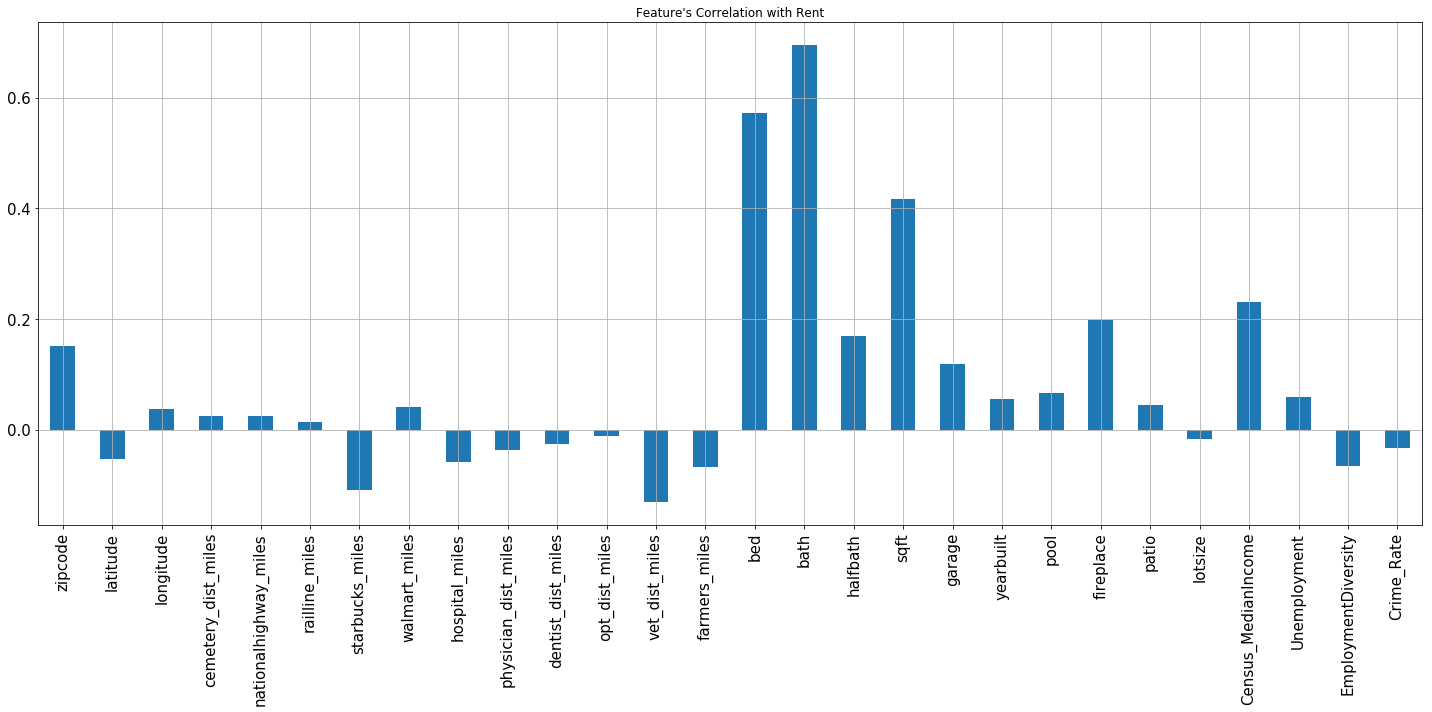

In [427]:
import matplotlib.pyplot as plt
train_data.drop('rent',axis=1).corrwith(train_data.rent).plot.bar(figsize = (20, 10), 
                                       title = "Feature's Correlation with Rent", fontsize = 15,
                                       rot = 90, grid = True);
save_fig("features_correlation_plot")

In [428]:
corr_col_todrop = correlation1(train_data.drop('rent',axis=1), 0.50)
print(corr_col_todrop)

[['hospital_miles', 'cemetery_dist_miles'], ['hospital_miles', 'railline_miles'], ['hospital_miles', 'starbucks_miles'], ['physician_dist_miles', 'nationalhighway_miles'], ['physician_dist_miles', 'railline_miles'], ['physician_dist_miles', 'hospital_miles'], ['dentist_dist_miles', 'nationalhighway_miles'], ['dentist_dist_miles', 'railline_miles'], ['dentist_dist_miles', 'starbucks_miles'], ['dentist_dist_miles', 'hospital_miles'], ['dentist_dist_miles', 'physician_dist_miles'], ['opt_dist_miles', 'nationalhighway_miles'], ['opt_dist_miles', 'railline_miles'], ['opt_dist_miles', 'walmart_miles'], ['opt_dist_miles', 'hospital_miles'], ['opt_dist_miles', 'physician_dist_miles'], ['opt_dist_miles', 'dentist_dist_miles'], ['farmers_miles', 'starbucks_miles'], ['farmers_miles', 'hospital_miles'], ['farmers_miles', 'physician_dist_miles'], ['farmers_miles', 'dentist_dist_miles'], ['farmers_miles', 'opt_dist_miles'], ['bath', 'bed'], ['sqft', 'bed'], ['Crime_Rate', 'Census_MedianIncome']]


Saving figure distribution_independent_histplot


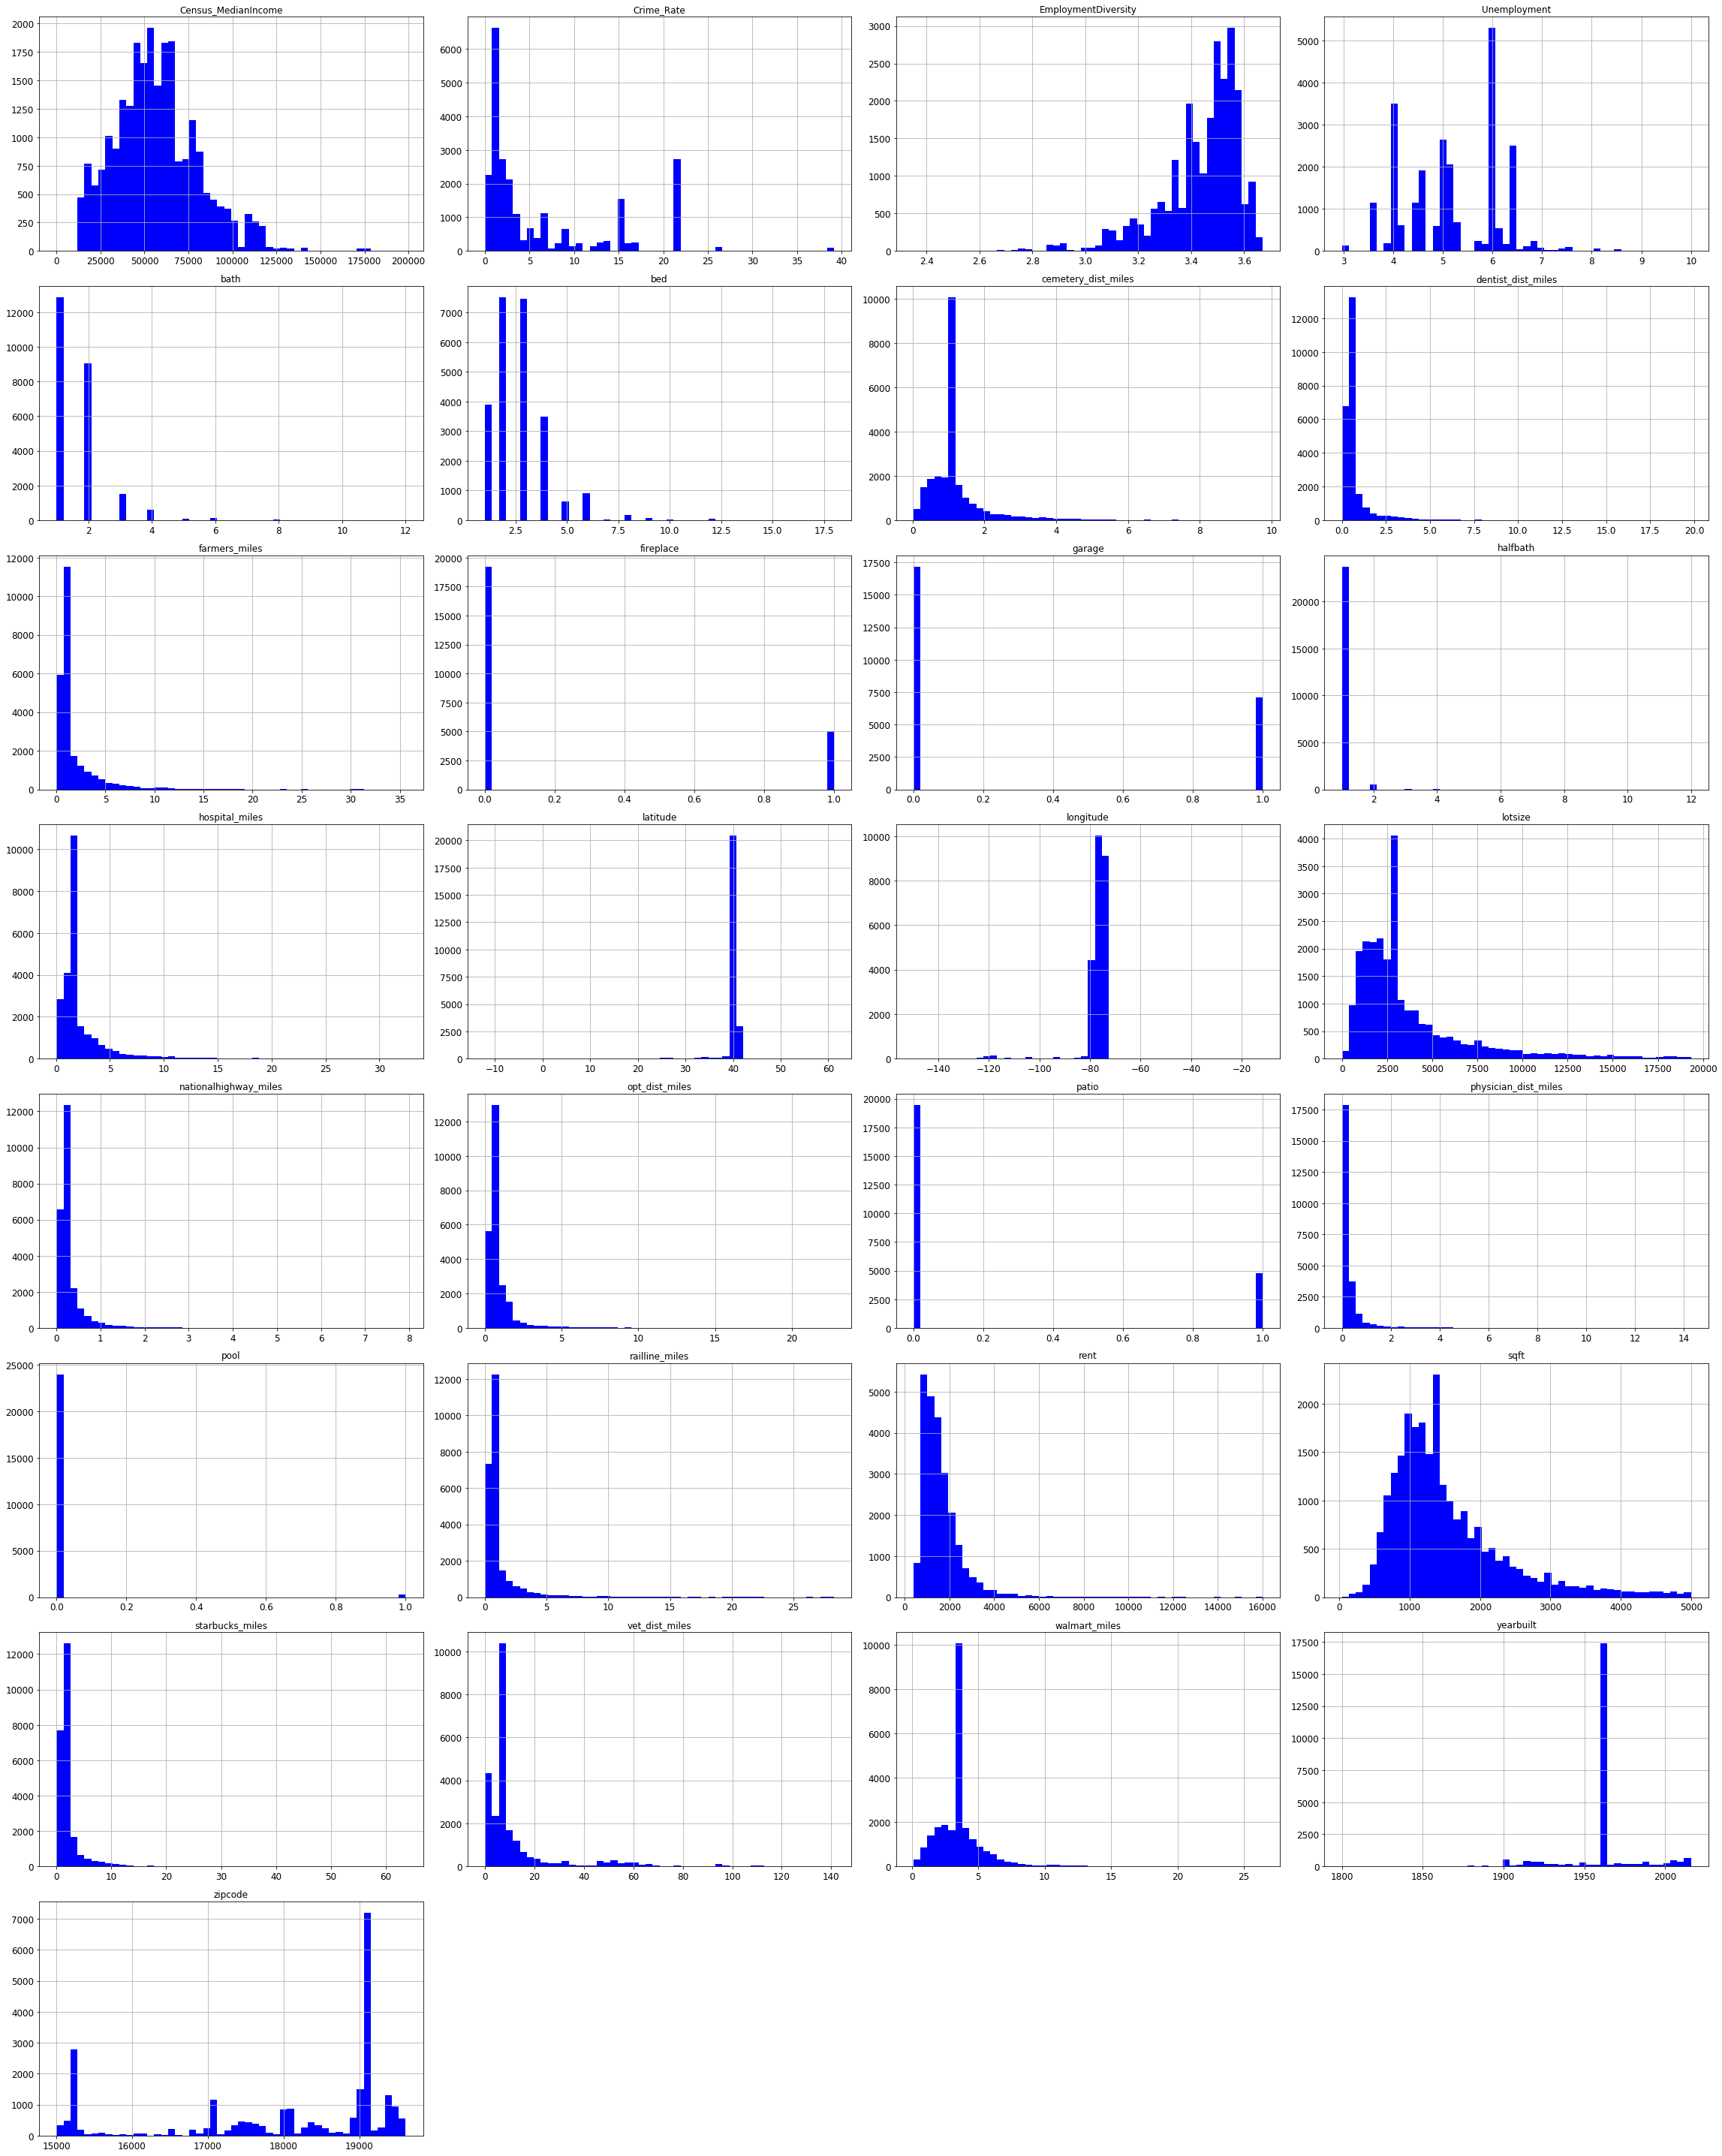

In [429]:
import matplotlib.pyplot as plt
#Check the distribution of all the independent variables
train_data.hist(bins=50,color='blue',figsize=(32,40), layout=(8,4))
save_fig("distribution_independent_histplot")
plt.show()

Saving figure outlier_plot


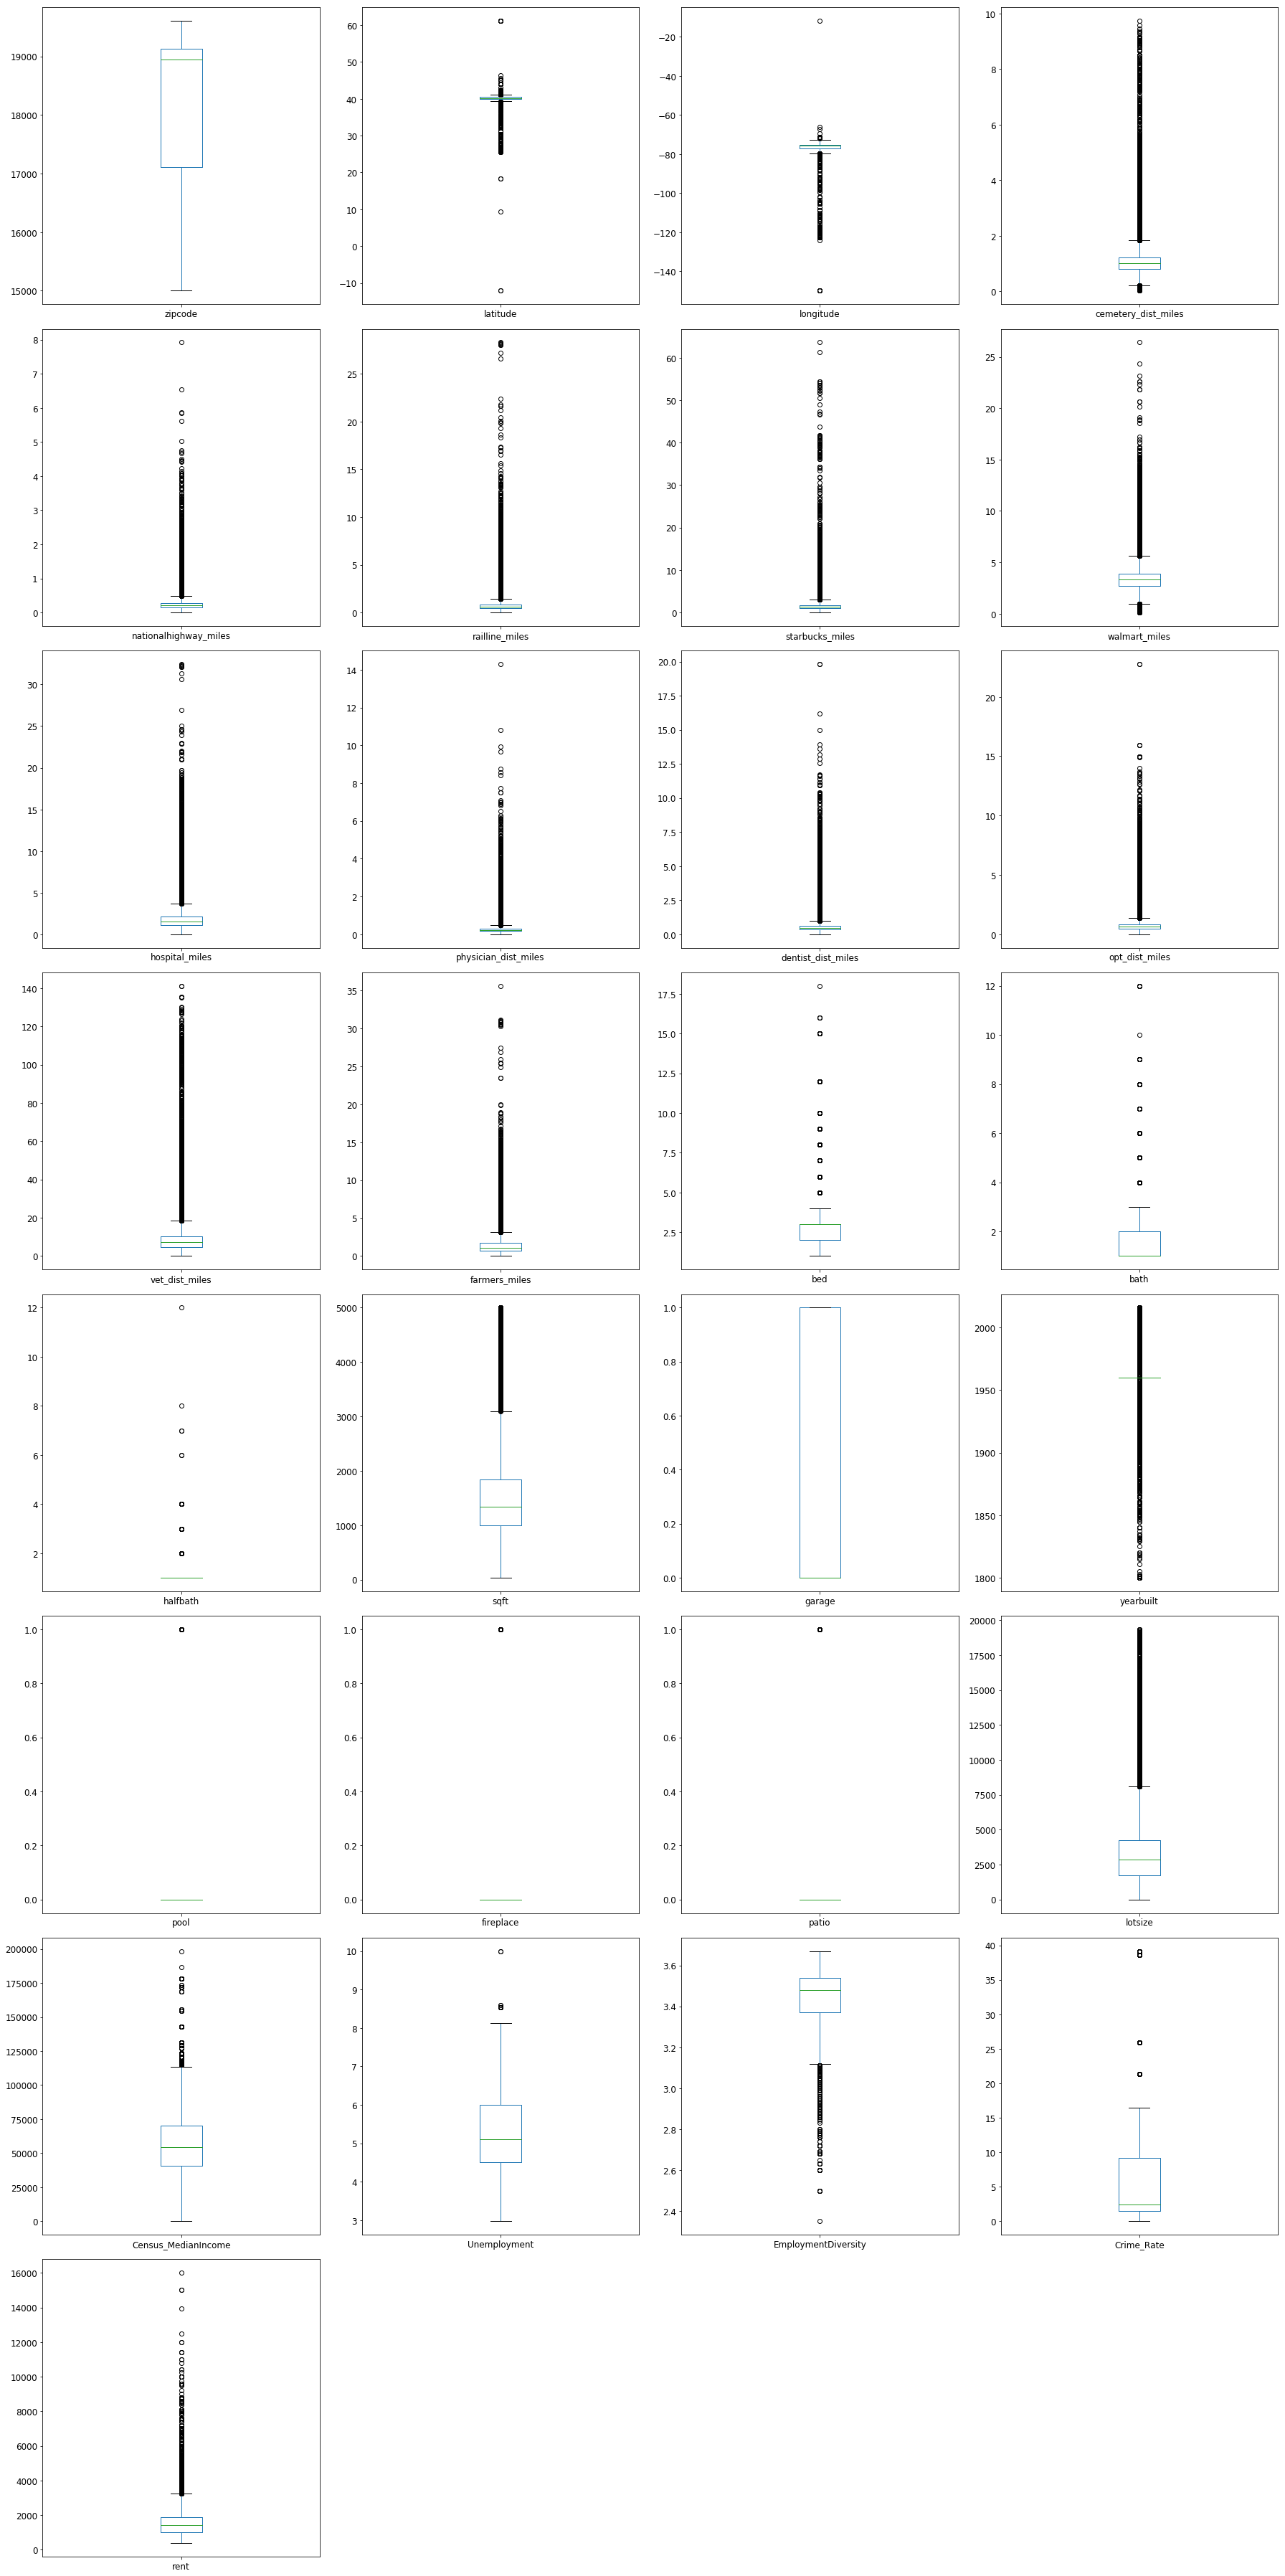

In [430]:
import matplotlib.pyplot as plt
#sns.boxplot(x=corr_Xtrain['property_type'])
train_data.plot(kind='box',subplots=True, figsize=(25,50), layout=(8,4))
save_fig("outlier_plot")
plt.show()

# No outliers present for property_type, zipcode
# bed, bath - needs to check outlier removal performance
# garage, pool, fireplace, patio have just two values. Hence, cannot be considered as outlier
# Also halfbath can be ignored, while checking for outliers as it has just 7 unique values.
# ['property_type', 'zipcode', 'garage', 'pool', 'fireplace', 'patio'] - Skipped from outlier removal

Saving figure scatter_matrix_plot


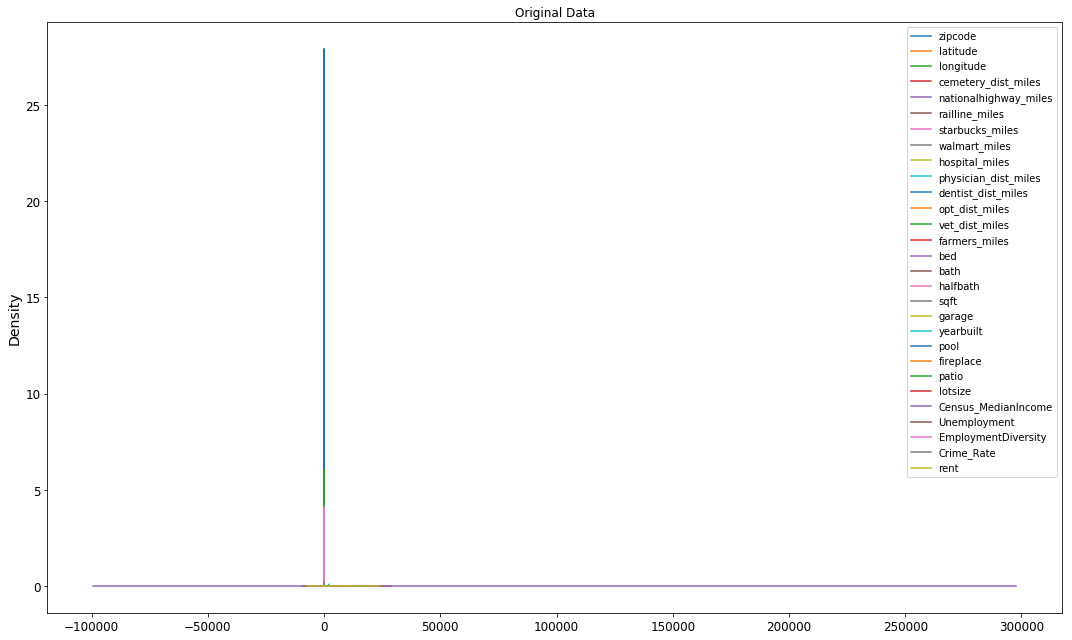

In [431]:
train_data.plot(kind='kde', title="Original Data",figsize=(15,9))
save_fig("scatter_matrix_plot")

Saving figure skewness_plot1
Saving figure skewness_plot2
Skewness: 3.359593
Kurtosis: 22.897583


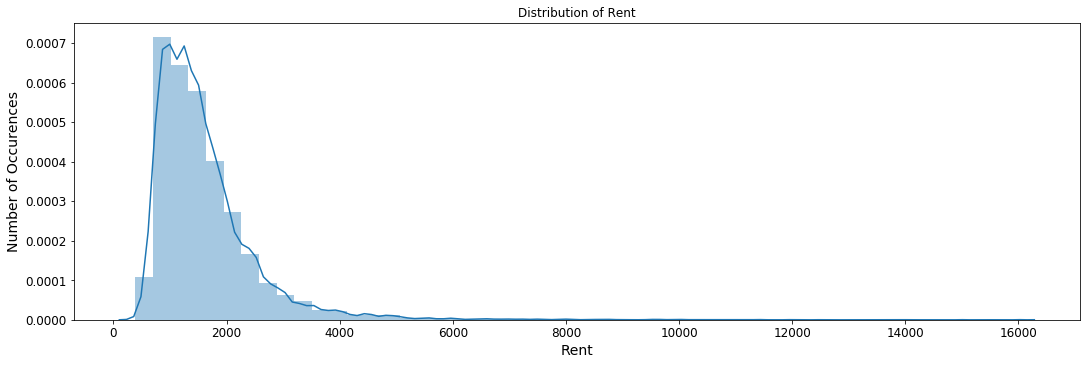

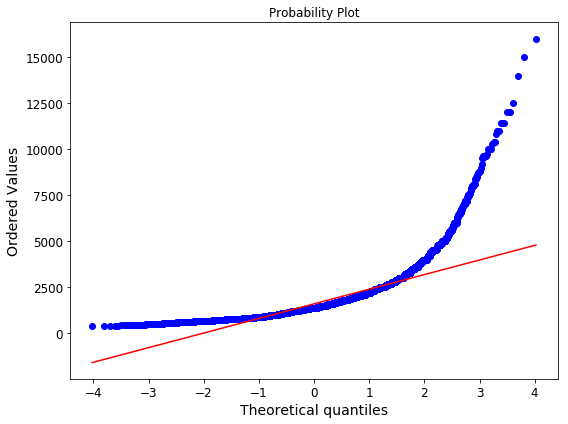

In [467]:
# Plot histogram to graphically show skewness and kurtosis
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=[15,5])
sns.distplot(train_data.rent)
save_fig("skewness_plot1")
plt.title('Distribution of Rent')
plt.xlabel('Rent')
plt.ylabel('Number of Occurences')

# normal probability plot
plt.figure(figsize=[8,6])
stats.probplot(train_data.rent, plot=plt)
save_fig("skewness_plot2")

# Calculate skewness and kurtosis values of target variable (rent)
print("Skewness: %f" % train_data.rent.skew())
print("Kurtosis: %f" % train_data.rent.kurt())

#Output_below
#Skewness: 3.391721
#Kurtosis: 23.032647

Skewness: 0.548909
Kurtosis: 0.604432


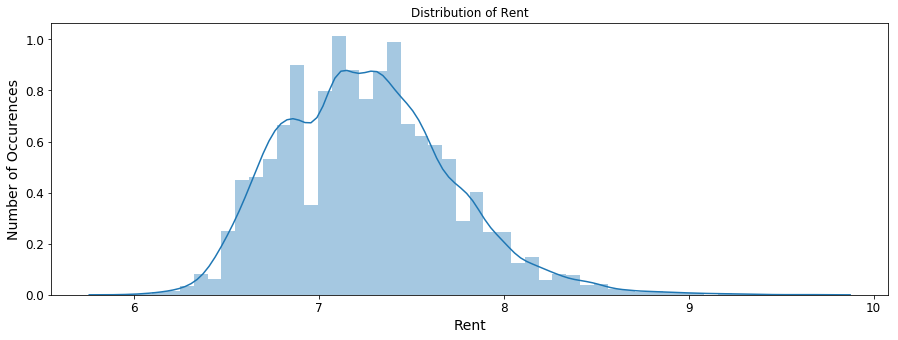

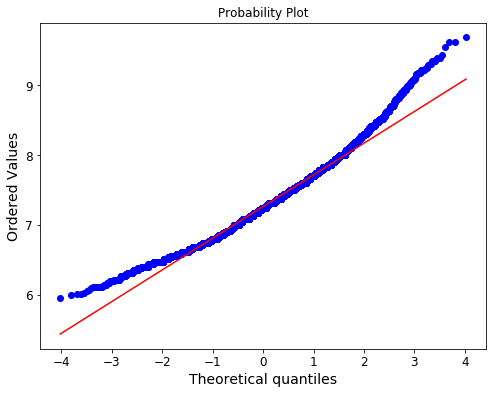

In [433]:

# Plot histogram to graphically show skewness and kurtosis

plt.figure(figsize=[15,5])
sns.distplot(np.log(train_data.rent))
plt.title('Distribution of Rent')
plt.xlabel('Rent')
plt.ylabel('Number of Occurences')

# normal probability plot
plt.figure(figsize=[8,6])
stats.probplot(np.log(train_data.rent), plot=plt)

# Calculate skewness and kurtosis values of target variable (rent)
print("Skewness: %f" % np.log(train_data.rent).skew())
print("Kurtosis: %f" % np.log(train_data.rent).kurt())

#Output_below
#Skewness: 0.546390
#Kurtosis: 0.617851

In [465]:
## $xpr_param_component_name = prepare_data
## $xpr_param_component_type = pipeline_job 
## $xpr_param_global_variables = ["train_data","test_data","Xtrain_Zs","ytrain_log","yvalid_log","Xvalid_scaled","yfull","Xfull","num_columns","cat_columns","X1","Xtrain","Xvalid","ytrain", "yvalid","X_num","na_num","X_ntrain","X_nvalid","imputed_X_ntrain","imputed_X_nvalid","Xtrain_u1","Xvalid_u1","X_cat","na_cat","imputed_X_ctrain","imputed_X_cvalid" ,"label_Xtrain", "label_Xvalid","corr_col_todrop","corr_Xtrain","corr_Xvalid","straindata","svaliddata","Xtrain_scaled","Xvalid_scaled","modelScore","rmseScore","ytrain_Zs","ytrain_log","yvalid_log"]

# Get the count of categorical and numerical features in the training dataset.
cat = len(train_data.select_dtypes(include=['object']).columns)
num = len(train_data.select_dtypes(exclude=['object']).columns)
#cat,num
print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')

Total Features:  5 categorical + 29 numerical = 34 features


In [435]:
# Data Pre-processing
# 1. Remove duplicates
# 2. Split training dataset to Xfull and yfull
# 3. Find numerical columns
# 4. Find categorical columns and remove high cardinality(unique values more than 15)
#    Also, remove categorical columns with single unique values
# 5. Updating X1 after clearing out high cardinal and single unique categorical variables from Xfull.
#    (Same step has to be done to test data)
# 6. Check for missing values in X1 training dataset.
# 7. Split X1,yfull to training and validation datas
# 8. Find best approach to handle missing data with numerical columns
# 9. Find best approach to handle missing data with categorical columns(if imputed, then we have to encode it), then check RMSE
# 10.Check or strong correlations between parameters. If so, then remove one of the parameters.

In [436]:
# Function for removing duplicates from housing rental full training dataset
def remove_duplicates():
    train_data.drop_duplicates(inplace=True)
    
    # Find the number of rows and columns inside the training dataset
    print("Shape after dropping duplicates as Row index:" ,train_data.shape)

In [437]:
# Step 1 :- Removing duplicate rows/examples from training dataset to avoid bias.
remove_duplicates()

Shape after dropping duplicates as Row index: (24060, 34)


# Splitting training dataset to Xfull and yfull

In [438]:
# Step 2 :- Split training data to X(feature variables) and y(target variable)
yfull = train_data.rent
Xfull = train_data.drop(['rent'],axis=1)

In [439]:
# Step 3 :- Get numerical columns
num_columns = [col for col in Xfull.columns if Xfull[col].dtype not in ['object']]
print(len(num_columns),num_columns)

# Total of 28 numerical variables are present.

28 ['zipcode', 'latitude', 'longitude', 'cemetery_dist_miles', 'nationalhighway_miles', 'railline_miles', 'starbucks_miles', 'walmart_miles', 'hospital_miles', 'physician_dist_miles', 'dentist_dist_miles', 'opt_dist_miles', 'vet_dist_miles', 'farmers_miles', 'bed', 'bath', 'halfbath', 'sqft', 'garage', 'yearbuilt', 'pool', 'fireplace', 'patio', 'lotsize', 'Census_MedianIncome', 'Unemployment', 'EmploymentDiversity', 'Crime_Rate']


In [440]:
# Step 4 :- Find categorical columns and remove high cardinality(unique values more than 15)
#           Also, remove categorical columns with single unique values

# Print all categorical columns first
print(Xfull.select_dtypes(include='object').columns)

# There are 5 categorical variables in the full training dataset.

# Get categorical columns from Xfull, which have low cardinality and have more than one unique values.
cat_columns = [col for col in Xfull.columns 
               if Xfull[col].dtype in ['object'] and 
               Xfull[col].nunique() <15 and 
               Xfull[col].nunique() > 1]
print(len(cat_columns),cat_columns)

# After removing high cardinal columns(county, city,address) and columns with only 1 unique value(for state),
# we are only left with just one categorical column.
# Also, it will be ok to lose address, county, city and state as we have numerical variables latitude and longitude.

Index(['county', 'city', 'address', 'state', 'property_type'], dtype='object')
1 ['property_type']


In [441]:
# Step 5 :- Updating X1 after clearing out high cardinal and single unique categorical variables from Xfull.
X1 = Xfull[cat_columns+num_columns].copy()
print("Shape after initial preprocessing:" ,X1.shape)
#X1.head()

Shape after initial preprocessing: (24060, 29)


In [442]:
from sklearn.model_selection import train_test_split

# Divide entire training dataset(X1,yfull) into training and validation subsets
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X1, yfull, train_size=0.8, test_size=0.2, random_state=0)

# Missing values Analysis on Numerical variables

In [443]:
# Create X_num without any objects to get numerical missing values variables
X_num = X1.select_dtypes(exclude=['object'])

na_num = [var for var in X_num.columns if X_num[var].isnull().sum() > 0]
print("Missing values(Numerical) column:", na_num)

Missing values(Numerical) column: ['zipcode']


In [444]:
#from sklearn.model_selection import train_test_split

## Divide numerical training dataset into training and validation subsets
#X_ntrain, X_nvalid, y_ntrain, y_nvalid = train_test_split(X_num, yfull, train_size=0.8, test_size=0.2, random_state=0)

X_ntrain = Xtrain.select_dtypes(exclude=['object'])
X_nvalid = Xvalid.select_dtypes(exclude=['object'])

#X_ntrain.head()

# 1. Dropping all missing value containing columns

# 2. Imputation

In [445]:
from sklearn.impute import SimpleImputer

def imputation(X_t, X_v, y_t, y_v, na_var, s='mean', f=None, buildOn=True):
    
    # Going to impute only, those missing value columns. Else, the entire datatype will get wrong.
    naX_t = X_t[na_var].copy()
    naX_v = X_v[na_var].copy()
    
    # Imputation
    imputer = SimpleImputer(strategy=s, fill_value=f)
    imputed_X_t = pd.DataFrame(imputer.fit_transform(naX_t))
    imputed_X_v = pd.DataFrame(imputer.transform(naX_v))
    
    # Imputation removed column names; put them back
    imputed_X_t.columns = naX_t.columns
    imputed_X_v.columns = naX_v.columns
    
    # Imputation removed index names; put them back
    imputed_X_t.set_index(naX_t.index,inplace=True)
    imputed_X_v.set_index(naX_v.index,inplace=True)
    
    # Updating the given training and validation dataset after imputation
    imputed_X_train = pd.concat([imputed_X_t, X_t.drop(na_var,axis=1)],axis=1)
    imputed_X_valid = pd.concat([imputed_X_v, X_v.drop(na_var,axis=1)],axis=1)
    
#    if buildOn:
#        rmse = rf_score_dataset(imputed_X_train,imputed_X_valid, y_t, y_v)
#        print("RMSE from Approach 2 (Imputation-"+ s + "):", rmse)
#        return rmse,imputed_X_train,imputed_X_valid
#    else:
#        return imputed_X_train,imputed_X_valid

    return imputed_X_train,imputed_X_valid

# KNN imputer for filling missing numerical column

In [446]:
# Find the best approach in imputation by comparing different imputation strategies like
# median, most_frequent, constant
#nimpute_RMSE, imputed_X_ntrain,imputed_X_nvalid = imputation(X_ntrain,X_nvalid,ytrain,yvalid,na_num,'most_frequent')
imputed_X_ntrain,imputed_X_nvalid = imputation(X_ntrain,X_nvalid,ytrain,yvalid,na_num,'most_frequent')

# Categorical Variables' Preprocessing

In [447]:
import pandas as pd
## Now, update Xtrain, Xvalid zipcode column with values from imputed_X_ntrain and imputed_X_nvalid
#Xtrain_u1 = pd.concat([Xtrain[cat_columns],imputed_X_ntrain],axis=1)
#Xvalid_u1 = pd.concat([Xvalid[cat_columns],imputed_X_nvalid],axis=1)

# Now, update Xtrain, Xvalid zipcode column with values from imputed_X_ntrain_plus and imputed_X_nvalid_plus
Xtrain_u1 = pd.concat([Xtrain[cat_columns],imputed_X_ntrain],axis=1)
Xvalid_u1 = pd.concat([Xvalid[cat_columns],imputed_X_nvalid],axis=1)

#Xtrain_u1.head()
#Xvalid_u1.head()
#missingValuesInfo(Xtrain_u1)

In [448]:
# Create X_cat without any numerical variables to get the number of categorical missing values
X_cat = X1.select_dtypes(include=['object'])

na_cat = [var for var in X_cat.columns if X_cat[var].isnull().sum() > 0]
print("Missing values(Categorical) column:", na_cat)

Missing values(Categorical) column: ['property_type']


In [449]:
# Approaches
#------------
# 1.(a). Drop columns with missing values (simplest approach)
#   (b). Drop Categorical Variables
# 2. Imputation (a. mostfrequent, b. constant)
# 3. Extended Imputation
# 4. K-NN

# 2. Label Encoding
Initial understanding is that, we can go with Label encoding for property_type as it has a ordinal value.

In [450]:
from sklearn.preprocessing import LabelEncoder

def labelEncoding(X_t, X_v, y_t, y_v,cat_cols):
    # Make copy to avoid changing original data
    label_X_train = X_t.copy()
    label_X_valid = X_v.copy()
    
    # Apply label encoder to each column with categorical data
    label_encoder = LabelEncoder()
    
    for col in cat_cols:
        label_X_train[col] = label_encoder.fit_transform(X_t[col])
        label_X_valid[col] = label_encoder.transform(X_v[col])
        
#    rmse = rf_score_dataset(label_X_train, label_X_valid, y_t, y_v)
#    print("RMSE from Approach 2 (Label Encoding):", rmse)
#    
#    return rmse, label_X_train, label_X_valid

    return label_X_train, label_X_valid

# 3. One-Hot Encoding

# Imputation

In [451]:
imputed_X_ctrain,imputed_X_cvalid     = imputation(Xtrain_u1, Xvalid_u1, ytrain, yvalid, cat_columns,'most_frequent',None,False)
#labelRMSE, label_Xtrain, label_Xvalid = labelEncoding(imputed_X_ctrain, imputed_X_cvalid, ytrain, yvalid,cat_columns)
label_Xtrain, label_Xvalid = labelEncoding(imputed_X_ctrain, imputed_X_cvalid, ytrain, yvalid,cat_columns)

#RMSE from Approach 2 (Label Encoding): 389.76461144850356
#RMSE from Approach 3 (One-Hot Encoding): 389.8877617399726

In [452]:
# Drop columns with correlation more than 50%. 
# But 'bath', 'bed', 'sqft', 'Crime_Rate', 'Census_MedianIncome'
#'railline_miles', 397.04901686391366 kept for better accuracy.

corr_col_todrop = {'cemetery_dist_miles', 'starbucks_miles', 'dentist_dist_miles',
                  'nationalhighway_miles', 'hospital_miles', 'physician_dist_miles'
                  }

corr_Xtrain = label_Xtrain.drop(corr_col_todrop,axis=1)
corr_Xvalid = label_Xvalid.drop(corr_col_todrop,axis=1)

#print("RMSE :",rf_score_dataset(corr_Xtrain, corr_Xvalid, ytrain, yvalid))

# b. Data Scaling: Normalization & Standardization

# Standardization

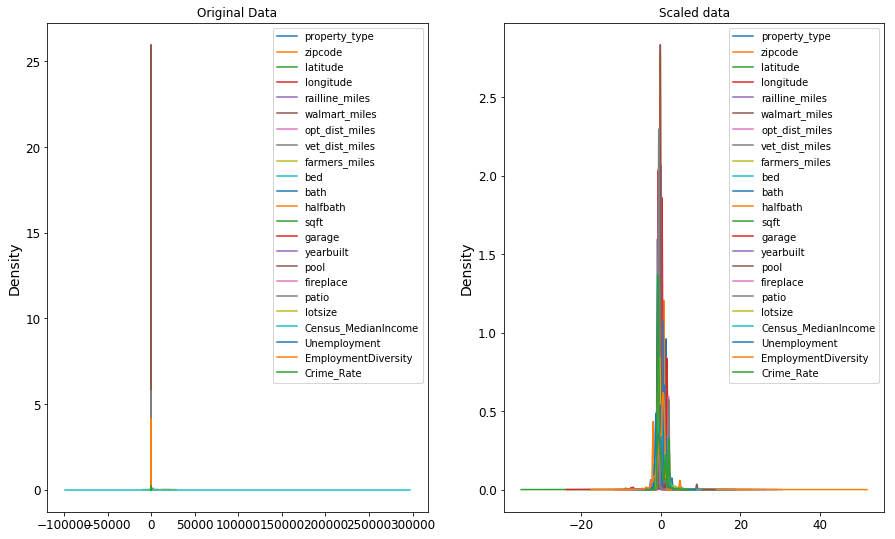

In [453]:
from sklearn.preprocessing import StandardScaler

# for min_max scaling
#from mlxtend.preprocessing import minmax_scaling

#num_cols = corr_Xtrain.select_dtypes(exclude='object').columns

# Standardization applies only to Numerical variables
straindata = corr_Xtrain.copy()
svaliddata = corr_Xvalid.copy()

## apply standardization on numerical features
#for i in num_cols[1:]:
#    
#    # fit on training data column
#    scaler = StandardScaler().fit(straindata[[i]])
#    
#    # transform the training data column
#    straindata[i] = scaler.fit_transform(straindata[[i]])
#    
#    
#    svaliddata[i] = scaler.transform(svaliddata[[i]])


scaler = StandardScaler()  
straindata = pd.DataFrame(scaler.fit_transform(straindata))  # fit and transform the training data column
svaliddata = pd.DataFrame(scaler.transform(svaliddata))      # transform the validation data column

# Imputation removed column names; put them back
straindata.columns = corr_Xtrain.columns
svaliddata.columns = corr_Xvalid.columns

# Imputation removed index names; put them back
straindata.set_index(corr_Xtrain.index,inplace=True)
svaliddata.set_index(corr_Xvalid.index,inplace=True)


# distplot is not working inside xpresso jupyter.
#sns.distplot(corr_Xtrain, ax=ax[0])
#ax[0].set_title("Original Data")
#sns.distplot(straindata, ax=ax[1])
#ax[1].set_title("Scaled data")

# plot the density plot of both initial and standardized data together to compare.
fig, ax = plt.subplots(1,2)
corr_Xtrain.plot(kind='kde', title="Original Data",ax=ax[0],figsize=(15,9))
straindata.plot(kind='kde', title="Scaled data",ax=ax[1],figsize=(15,9))
plt.show()

#print("RMSE :",rf_score_dataset(straindata, svaliddata, ytrain, yvalid))

In [454]:
# Based on RMSE score for Random forest. Going to proceed with standardized data.
Xtrain_scaled = straindata.copy()
Xvalid_scaled = svaliddata.copy()

# 1. Zscore test

In [455]:
from scipy import stats
import numpy as np
def zscore_test(m, X_t, X_v, y_t, y_v):
    # Get Zscore for full train dataset
    z = np.abs(stats.zscore(X_t))

    print("Number of outliers present using Z-score method:",pd.DataFrame(np.where(z > 3)).size)

    # Updating train dataset after removing outliers(having zscore above 3)
    Xt_Zs = X_t[(z < 3).all(axis=1)]
    yt_Zs = y_t[(z < 3).all(axis=1)]

    print("New Xtrain Shape:" ,Xt_Zs.shape ,"\nNew ytrain Shape:" , yt_Zs.shape)
    
    # Calculate Model Score and RMSE score for different models using dataset having outlier removed using Z-score method.
    modelScore, rmseScore = score_dataset(m, Xt_Zs, X_v, yt_Zs, y_v)
    return modelScore , rmseScore, Xt_Zs, yt_Zs

# (19248, 27) Original shape

# 2. IQR Method

In [456]:
import numpy as np
import pandas as pd
def IQR_test(m, X_t, X_v, y_t, y_v):
    Q1 = X_t.quantile(0.25) # Get first quantile
    Q3 = X_t.quantile(0.75) # Get 3rd quantile
    IQR = Q3 - Q1           # Calculate Inter-quartile range


    print("Number of outliers present using IQR method:", 
          pd.DataFrame((X_t < (Q1 - 1.5 * IQR)) |(X_t > (Q3 + 1.5 * IQR))).sum().sum())

    # Updating train dataset after removing outliers using IQR method.
    Xt_IQR = X_t[~((X_t < (Q1 - 1.5 * IQR)) |(X_t > (Q3 + 1.5 * IQR))).any(axis=1)]
    yt_IQR = ytrain[Xt_IQR.index]

    print("New Xtrain Shape:" ,Xt_IQR.shape ,"\nNew ytrain Shape:" , yt_IQR.shape)
    
    # Calculate Model Score and RMSE score for different models using dataset having outlier removed using IQR method.
    modelScore, rmseScore = score_dataset(m, Xt_IQR, X_v, yt_IQR, y_v)

    return modelScore , rmseScore, Xt_IQR, yt_IQR

# Outlier check and removal for each feature.

In [457]:
# Getting zscore for Crime_Rate column alone.
# As outlier removal for Crime_Rate is giving best result.
z = np.abs(stats.zscore(Xtrain_scaled.drop([
    'property_type',         # 372.3876
    'zipcode',               # 372.3876
    'latitude',              # 389
    'longitude',             # 392
    #'cemetery_dist_miles',   # 371.215
    #'nationalhighway_miles', # 389
    'railline_miles',        # 377
    #'starbucks_miles',       # 383
    'walmart_miles',         # 388
    #'hospital_miles',        # 381
    'opt_dist_miles',        # 369.817798
    'vet_dist_miles',        # 381
    'farmers_miles',         # 379
    'bed',                   # 394
    'bath',                  # 375
    'halfbath',              # 371.9698
    'sqft',                  # 377
    'garage',                # 372.3876
    'yearbuilt',             # 373
    'pool',                  # 368.4677
    'fireplace',             # 372.3876
    'patio',                 # 372.3876
    'lotsize',               # 383
    'Census_MedianIncome',   # 382
    'Unemployment',          # 401
    'EmploymentDiversity',   # 379
    #'Crime_Rate'            # 365.17925
],axis=1)))

# Get number of rows having zscore > 3. (Outlier)
print("Number of outliers present using Z-score method for Crime_rate column:",pd.DataFrame(np.where(z > 3)).size)

# store dataset after removing outliers.
Xtrain_Zs = Xtrain_scaled[(z < 3).all(axis=1)]
ytrain_Zs = ytrain[(z < 3).all(axis=1)]

# Display shape of updated dataset after Outlier removal
print("New Xtrain Shape:" ,Xtrain_Zs.shape ,"\nNew ytrain Shape:" , ytrain_Zs.shape)

# (19248, 27) Original shape

Number of outliers present using Z-score method for Crime_rate column: 148
New Xtrain Shape: (19174, 23) 
New ytrain Shape: (19174,)


# d. Check Skewness/Kurtosis

In [458]:
ytrain_log = np.log(ytrain_Zs)
yvalid_log = np.log(yvalid)


In [ ]:
## $xpr_param_component_name = linear_model	
## $xpr_param_component_type = pipeline_job
## $xpr_param_global_variables = ["train_data","test_data","Xtrain_Zs","ytrain_Zs","ytrain_log","yvalid_log","Xvalid_scaled","Xtrain_scaled"]


In [459]:
# Models from Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import numpy as np


#from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Put models in a dictionary
test_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree    ": DecisionTreeRegressor(random_state=0),
    "Random Forest    ": RandomForestRegressor(random_state=0),
    "KNN              ": KNeighborsRegressor(),
    "XGBoost          ": XGBRegressor(random_state=0)
}

# Create a function to fit and score models
def score_dataset(models, X_t, X_v, y_t, y_v, lg=False):
    
    # Make a dictionary to keep model scores and RMSE 
    model_scores = {}
    rmse_scores  = {}
    
    print("Train")
    
    # Loop through models
    for modelname, model in models.items():
        
        # Fit the model to the data
        model.fit(X_t, y_t)
        preds_train = model.predict(X_t)
        preds = model.predict(X_v)
        
        print(modelname + ":" + str(model.score(X_t, y_t)))
        
        # Evaluate the model and append its score to model_scores
        model_scores[modelname] = model.score(X_v, y_v)
        
        if lg:
            preds = np.exp(preds)
            preds_train = np.exp(preds_train)
            yv = np.exp(y_v)
            yt = np.exp(y_t)
        else:
            yt = y_t.copy()
            yv = y_v.copy()
        
        print(modelname + ":" + str(np.sqrt(mean_squared_error(yt, preds_train))))
        rmse_scores[modelname] = np.sqrt(mean_squared_error(yv, preds))
        
    return model_scores, rmse_scores



In [460]:
modelScore, rmseScore = score_dataset(test_models, Xtrain_Zs, Xvalid_scaled, ytrain_log, yvalid_log,True)
modelScore , rmseScore

Train
Linear Regression:0.6340688342537193
Linear Regression:615.4302391819923
Decision Tree    :0.9996142138481151
Decision Tree    :18.02360475868277
Random Forest    :0.976320692256028
Random Forest    :160.75540215087014
KNN              :0.8085025379828743
KNN              :417.92443617096234
XGBoost          :0.9138764882749367
XGBoost          :244.32844403259224


({'Linear Regression': 0.6307571949263513,
  'Decision Tree    ': 0.6740586539156559,
  'Random Forest    ': 0.8352639366447743,
  'KNN              ': 0.7094701838194613,
  'XGBoost          ': 0.8437560962544198},
 {'Linear Regression': 686.2456444170666,
  'Decision Tree    ': 537.150617410129,
  'Random Forest    ': 384.2063808889948,
  'KNN              ': 500.5923287735548,
  'XGBoost          ': 354.967446992847})

In [461]:
XGBmodel = XGBRegressor(n_estimators=2000, learning_rate=0.1, n_jobs=4, random_state = 101)
XGBmodel.fit(Xtrain_Zs, ytrain_Zs, 
            # early_stopping_rounds = 5, 355.71612921117776 2000, 354.7684598810383
             eval_set=[(Xvalid_scaled, yvalid)],
             eval_metric='rmse',
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=4, num_parallel_tree=1, random_state=101,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [462]:
print("XGBoost Regression R^2 Score: ", XGBmodel.score(Xtrain_Zs, ytrain_Zs))
print("XGBoost Regression Test R^2 Score: ", XGBmodel.score(Xvalid_scaled, yvalid))

xgbReg_ytrain = XGBmodel.predict(Xtrain_Zs)
print("XGBoost Regression RMSE train: ", np.sqrt(mean_squared_error(xgbReg_ytrain, ytrain_Zs)))

xgbReg_ycvpred = XGBmodel.predict(Xvalid_scaled)
print("XGBoost Regression RMSE test: ", np.sqrt(mean_squared_error(xgbReg_ycvpred, yvalid)))

XGBoost Regression R^2 Score:  0.9921641875839979
XGBoost Regression Test R^2 Score:  0.8426463713246697
XGBoost Regression RMSE train:  81.2165804638872
XGBoost Regression RMSE test:  354.7684598810383
